<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo sequence to sequence - Traductor

### Consigna

Replicar y extender el traductor:
- Replicar el modelo en PyTorch.
- Extender el entrenamiento a más datos y tamaños de secuencias mayores.
- Explorar el impacto de la cantidad de neuronas en las capas recurrentes.
- Mostrar 5 ejemplos de traducciones generadas.

Extras que se pueden probar: 
- Embeddingspre-entrenados para los dos idiomas
- Cambiar la estrategia de generación (por ejemplo muestreo aleatorio)

## 1. Datos

In [155]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [156]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
from torchinfo import summary

import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

In [157]:
# Descargar la carpeta de dataset
import gdown
import zipfile
if os.access('spa-eng', os.F_OK) is False:
    if os.access('simpsons_dataset.zip', os.F_OK) is False:
        url = 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
        output = os.path.join("./Dataset", "spa-eng.zip")
        gdown.download(url, output, quiet=False)
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall("./Dataset")
else:
    print("El dataset ya se encuentra descargado")

# dataset_file

text_file = os.path.join("./Dataset", "spa-eng/spa.txt")
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]


Downloading...
From: http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
To: /home/agustin/Desktop/CEIA UBA/Procesamiento Lenguaje Natural I/CEIA-ProcesamientoLenguajeNaturalI/Desafio_4/Dataset/spa-eng.zip
100%|██████████| 2.64M/2.64M [00:03<00:00, 869kB/s]


### Funciones de guardado del modelo

In [158]:
import json

def save_checkpoint(folder, model, optimizer, history, config,
                    input_tokenizer, output_tokenizer,
                    word2idx_inputs, word2idx_outputs, embedding_matrix, embedding_matrix_decoder=None):
    """
    Guarda todos los elementos necesarios para reconstruir el entrenamiento.
    """
    os.makedirs(folder, exist_ok=True)

    torch.save(model.state_dict(), os.path.join(folder, "seq2seq_model.pth"))
    torch.save(optimizer.state_dict(), os.path.join(folder, "optimizer_state.pth"))
    torch.save(config, os.path.join(folder, "config.pth"))

    np.save(os.path.join(folder, "embedding_matrix.npy"), embedding_matrix)
    if embedding_matrix_decoder is not None:
        np.save(os.path.join(folder, "embedding_matrix_decoder.npy"), embedding_matrix_decoder)

    with open(os.path.join(folder, "input_tokenizer.pkl"), "wb") as f:
        pickle.dump(input_tokenizer, f)
    with open(os.path.join(folder, "output_tokenizer.pkl"), "wb") as f:
        pickle.dump(output_tokenizer, f)
    with open(os.path.join(folder, "word2idx_inputs.pkl"), "wb") as f:
        pickle.dump(word2idx_inputs, f)
    with open(os.path.join(folder, "word2idx_outputs.pkl"), "wb") as f:
        pickle.dump(word2idx_outputs, f)

    with open(os.path.join(folder, "history.json"), "w") as f:
        json.dump(history, f)

    print(f"Checkpoint guardado en: {folder}")


def load_checkpoint(folder, Encoder, Decoder, Seq2Seq, device="cpu"):
    """
    Carga todo desde una carpeta y reconstruye el modelo listo para usar.
    Retorna: model, optimizer, history, config, tokenizers, vocabularios, embedding_matrix
    """
    # 1. Configuración
    config = torch.load(os.path.join(folder, "config.pth"), map_location=device)

    # 2. Tokenizers y vocabularios
    with open(os.path.join(folder, "input_tokenizer.pkl"), "rb") as f:
        input_tokenizer = pickle.load(f)
    with open(os.path.join(folder, "output_tokenizer.pkl"), "rb") as f:
        output_tokenizer = pickle.load(f)
    with open(os.path.join(folder, "word2idx_inputs.pkl"), "rb") as f:
        word2idx_inputs = pickle.load(f)
    with open(os.path.join(folder, "word2idx_outputs.pkl"), "rb") as f:
        word2idx_outputs = pickle.load(f)

    # 3. Embedding matrices (encoder obligatoria, decoder opcional)
    embedding_matrix_encoder = np.load(os.path.join(folder, "embedding_matrix.npy"))

    path_decoder = os.path.join(folder, "embedding_matrix_decoder.npy")
    embedding_matrix_decoder = np.load(path_decoder) if os.path.exists(path_decoder) else None

    vocab_size_encoder = int(embedding_matrix_encoder.shape[0])
    # 4. Modelo
    encoder = Encoder(
        vocab_size=vocab_size_encoder,
        embedding_matrix=embedding_matrix_encoder
    )

    if embedding_matrix_decoder is not None:
        decoder = Decoder(
            vocab_size=config["num_words_output"],
            output_dim=config["num_words_output"],
            embedding_matrix=embedding_matrix_decoder
        )
    else:
        print("No se encontró embedding_matrix_decoder.npy — se entrenará embedding en el Decoder.")
        decoder = Decoder(
            vocab_size=config["num_words_output"],
            output_dim=config["num_words_output"]
        )

    model = Seq2Seq(encoder, decoder)
    model.load_state_dict(torch.load(os.path.join(folder, "seq2seq_model.pth"), map_location=device))
    model.to(device)
    model.eval()

    # 5. Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
    optimizer.load_state_dict(torch.load(os.path.join(folder, "optimizer_state.pth"), map_location=device))

    # 6. Historia
    with open(os.path.join(folder, "history.json"), "r") as f:
        history = json.load(f)

    print(f"Checkpoint cargado desde: {folder}")

    return {
        "model": model,
        "optimizer": optimizer,
        "history": history,
        "config": config,
        "input_tokenizer": input_tokenizer,
        "output_tokenizer": output_tokenizer,
        "word2idx_inputs": word2idx_inputs,
        "word2idx_outputs": word2idx_outputs,
        "embedding_matrix": embedding_matrix
    }


def check_checkpoint_exists(folder):
    """
    Verifica si existen todos los archivos necesarios en la carpeta.
    Retorna True si el checkpoint está completo.
    """
    required_files = [
        "seq2seq_model.pth",
        "optimizer_state.pth",
        "config.pth",
        "embedding_matrix.npy",
        "input_tokenizer.pkl",
        "output_tokenizer.pkl",
        "word2idx_inputs.pkl",
        "word2idx_outputs.pkl",
        "history.json"
    ]

    missing = [f for f in required_files if not os.path.exists(os.path.join(folder, f))]
    if missing:
        print(f"Faltan archivos en el checkpoint: {missing}")
        return False
    print(f"Checkpoint completo encontrado en: {folder}")
    return True

## 2. Entrenamiento Baseline
Se tomará el modelo entrenado en clase como Baseline para comparación al aplicar cambios:

### 2.1. Limitación dataset

In [159]:
# Mezclar el dataset, forzar semilla siempre igual
np.random.seed([40])
np.random.shuffle(lines)

def generar_secuencias(lines, MAX_NUM_SENTENCES=6000):
    input_sentences = []
    output_sentences = []
    output_sentences_inputs = []
    count = 0

    for line in lines:
        count += 1
        if count > MAX_NUM_SENTENCES:
            break

        if '\t' not in line:
            continue

        # Input sentence --> eng
        # output --> spa
        input_sentence, output = line.rstrip().split('\t')

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)
    return input_sentences, output_sentences, output_sentences_inputs


# Por limitaciones de RAM no se leen todas las filas
MAX_NUM_SENTENCES = 6000
input_sentences, output_sentences, output_sentences_inputs = generar_secuencias(lines, MAX_NUM_SENTENCES)

print("Cantidad de rows disponibles:", len(lines))
print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 6000


In [160]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0]

('A deal is a deal.',
 'Un trato es un trato. <eos>',
 '<sos> Un trato es un trato.')

### 2.2. Preprocesamiento

In [161]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from torch_helpers import Tokenizer

def tokenizar_texto(input_sentences, output_sentences, output_sentences_inputs, MAX_VOCAB_SIZE=8000):
    input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
    input_tokenizer.fit_on_texts(input_sentences)
    input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

    word2idx_inputs = input_tokenizer.word_index
    print("Palabras en el vocabulario:", len(word2idx_inputs))

    max_input_len = max(len(sen) for sen in input_integer_seq)
    print("Sentencia de entrada más larga:", max_input_len)


    # A los filtros de símbolos del Tokenizer agregamos el "¿",
    # sacamos los "<>" para que no afectar nuestros tokens
    output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
    output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
    output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
    output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

    word2idx_outputs = output_tokenizer.word_index
    print("Palabras en el vocabulario:", len(word2idx_outputs))

    num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) # Se suma 1 por el primer <sos>
    max_out_len = max(len(sen) for sen in output_integer_seq)
    print("Sentencia de salida más larga:", max_out_len)

    return {
        'input_tokenizer': input_tokenizer,
        'output_tokenizer': output_tokenizer,
        'input_integer_seq': input_integer_seq,
        'output_integer_seq': output_integer_seq,
        'output_input_integer_seq': output_input_integer_seq,
        'word2idx_inputs': word2idx_inputs,
        'word2idx_outputs': word2idx_outputs,
        'max_input_len': max_input_len,
        'max_out_len': max_out_len,
        'num_words_output': num_words_output
    }

# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000

salida_tokenizador = tokenizar_texto(input_sentences, output_sentences, output_sentences_inputs, MAX_VOCAB_SIZE)

input_tokenizer = salida_tokenizador["input_tokenizer"]
output_tokenizer = salida_tokenizador["output_tokenizer"]
input_integer_seq = salida_tokenizador["input_integer_seq"]
output_integer_seq = salida_tokenizador["output_integer_seq"]
output_input_integer_seq = salida_tokenizador["output_input_integer_seq"]
num_words_output = salida_tokenizador["num_words_output"]
word2idx_inputs = salida_tokenizador["word2idx_inputs"]
word2idx_outputs = salida_tokenizador["word2idx_outputs"]


Palabras en el vocabulario: 3851
Sentencia de entrada más larga: 32
Palabras en el vocabulario: 5721
Sentencia de salida más larga: 36


In [162]:
# Por una cuestion de que no explote la RAM se limitará el tamaño de las sentencias de entrada
# a la mitad:
max_input_len = 16
max_out_len = 18

In [163]:
from torch_helpers import pad_sequences
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences shape:", decoder_output_sequences.shape)

Cantidad de rows del dataset: 6000
encoder_input_sequences shape: (6000, 16)
decoder_input_sequences shape: (6000, 18)
decoder_output_sequences shape: (6000, 18)


In [164]:
class Data(Dataset):
    def __init__(self, encoder_input, decoder_input, decoder_output):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.encoder_inputs = torch.from_numpy(encoder_input.astype(np.int32))
        self.decoder_inputs = torch.from_numpy(decoder_input.astype(np.int32))
        # Transformar los datos a oneHotEncoding
        # la loss function esperan la salida float
        # Para CrossEntropyLoss: guardar los targets como índices de clase (LongTensor),
        # shape = (N, seq_len), dtype = torch.int64
        self.decoder_outputs = torch.from_numpy(decoder_output).to(torch.int64)

        self.len = self.decoder_outputs.shape[0]

    def __getitem__(self,index):
        return self.encoder_inputs[index], self.decoder_inputs[index], self.decoder_outputs[index]

    def __len__(self):
        return self.len

data_set = Data(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences)

encoder_input_size = data_set.encoder_inputs.shape[1]
print("encoder_input_size:", encoder_input_size)

decoder_input_size = data_set.decoder_inputs.shape[1]
print("decoder_input_size:", decoder_input_size)

output_dim = num_words_output
print("Output dim", output_dim)

encoder_input_size: 16
decoder_input_size: 18
Output dim 5722


In [165]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False, drop_last=True)

Tamaño del conjunto de entrenamiento: 4800
Tamaño del conjunto de validacion: 1200


### 2.3. Preparar los embeddings

In [166]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Los embeddings gloveembedding.pkl ya están descargados


In [167]:
import logging
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [168]:
# Por una cuestion de RAM se utilizará los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

In [169]:
# Crear la Embedding matrix de las secuencias
# en ingles


def preparar_embedding_matrix(model_embeddings, word2idx_inputs, MAX_VOCAB_SIZE):
    embed_dim = model_embeddings.N_FEATURES
    words_not_found = []

    # word_index provieen del tokenizer

    nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs) + 1) # vocab_size
    embedding_matrix = np.zeros((nb_words, embed_dim))
    for word, i in word2idx_inputs.items():
        if i >= nb_words:
            continue
        embedding_vector = model_embeddings.get_words_embeddings(word)[0]
        if (embedding_vector is not None) and len(embedding_vector) > 0:
            
            embedding_matrix[i] = embedding_vector
        else:
            # words not found in embedding index will be all-zeros.
            words_not_found.append(word)

    print('Número de embeddings nulos:', np.sum(np.sum(embedding_matrix, axis=1) == 0))
    return embedding_matrix, words_not_found, nb_words

embedding_matrix, words_not_found, nb_words = preparar_embedding_matrix(model_embeddings, word2idx_inputs, MAX_VOCAB_SIZE)

Número de embeddings nulos: 30


In [170]:
nb_words

3852

In [171]:
# Dimensión de los embeddings de la secuencia en ingles
embedding_matrix.shape

(3852, 50)

### 2.4. Entrenar modelo

In [172]:
from tqdm import tqdm

class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_matrix):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 128
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1]
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)

class Decoder(nn.Module):
    def __init__(self, vocab_size, output_dim, embedding_matrix=None):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 128
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1] if embedding_matrix is not None else 50
        self.output_dim = output_dim

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)

        # Para utilizar versión con embedding preentrenados
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            self.embedding.weight.requires_grad = False  # 

        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim) # Fully connected layer

        self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        out = self.softmax(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        return out, (ht, ct)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        assert encoder.lstm_size == decoder.lstm_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, encoder_input, decoder_input):
        batch_size = decoder_input.shape[0]
        decoder_input_len = decoder_input.shape[1]
        vocab_size = self.decoder.output_dim
        
        # tensor para almacenar la salida
        # (batch_size, sentence_len, one_hot_size)
        outputs = torch.zeros(batch_size, decoder_input_len, vocab_size)
        
        # ultimo hidden state del encoder, primer estado oculto del decoder
        prev_state = self.encoder(encoder_input)
      
        # En la primera iteracion se toma el primer token de target (<sos>)
        input = decoder_input[:, 0:1]

        for t in range(decoder_input_len):
            # t --> token index

            # utilizamos método "teacher forcing", es decir que durante
            # el entrenamiento no realimentamos la salida del decoder
            # sino el token correcto que sigue en target
            input = decoder_input[:, t:t+1]

            # ingresar cada token embedding, uno por uno junto al hidden state
            # recibir el output del decoder (softmax)
            output, prev_state = self.decoder(input, prev_state)
            top1 = output.argmax(1).view(-1, 1)

            # Sino se usará "teacher forcing" habría que descomentar
            # esta linea.
            # Hay ejemplos dandos vuelta en donde se utilza un random 
            # para ver en cada vuelta que técnica se aplica
            #input = top1            

            # guardar cada salida (softmax)
            outputs[:, t, :] = output

        return outputs

encoder = Encoder(vocab_size=nb_words, embedding_matrix=embedding_matrix)
if cuda: encoder.to(device)
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
# asegurar consistencia: output_dim igual a num_words_output usado por dataset/one-hot
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.to(device)

model = Seq2Seq(encoder, decoder)
if cuda: model.to(device)

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica


### CORREGIR ERROR
#summary(model, input_data=(data_set[0:1][0], data_set[0:1][1]))

In [173]:
from tqdm import tqdm

def sequence_acc(y_pred, y_test):
    """
    Calcula la accuracy promedio por secuencia.
    y_pred: logits (batch, seq_len, vocab_size)
    y_test: índices (batch, seq_len)
    """
    y_pred_tag = y_pred.argmax(dim=-1)  # (batch, seq_len)
    y_test_tag = y_test if y_test.ndim == 2 else y_test.argmax(dim=-1)
    acc = (y_pred_tag == y_test_tag).float().mean().item()
    return acc


def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    train_loss, train_accuracy = [], []
    valid_loss, valid_accuracy = [], []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for train_encoder_input, train_decoder_input, train_target in loop:
            optimizer.zero_grad()

            # Forward
            output = model(train_encoder_input.to(device), train_decoder_input.to(device))


            # Calcular loss en toda la secuencia (más eficiente)
            loss = criterion(
                output.reshape(-1, output.shape[-1]),
                train_target.to("cpu").reshape(-1)
            )

            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            epoch_train_accuracy += sequence_acc(output, train_target)

        epoch_train_loss /= len(train_loader)
        epoch_train_accuracy /= len(train_loader)
        train_loss.append(epoch_train_loss)
        train_accuracy.append(epoch_train_accuracy)


        # --- VALIDACIÓN COMPLETA ---
        model.eval()
        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        with torch.no_grad():
            for valid_encoder_input, valid_decoder_input, valid_target in valid_loader:
                output = model(valid_encoder_input.to(device), valid_decoder_input.to(device))
                loss = criterion(
                    output.reshape(-1, output.shape[-1]),
                    valid_target.to("cpu").reshape(-1)
                )

                epoch_valid_loss += loss.item()
                epoch_valid_accuracy += sequence_acc(output, valid_target)

        epoch_valid_loss /= len(valid_loader)
        epoch_valid_accuracy /= len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch {epoch+1:02}/{epochs} | "
              f"Train loss: {epoch_train_loss:.3f} | "
              f"Train acc: {epoch_train_accuracy:.3f} | "
              f"Val loss: {epoch_valid_loss:.3f} | "
              f"Val acc: {epoch_valid_accuracy:.3f}")

    return {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }

In [174]:
carpeta = "Modelos_entrenados/Baseline"

modelo_entrenado = check_checkpoint_exists(carpeta)

if not modelo_entrenado:
    history1 = train(model,
                    train_loader,
                    valid_loader,
                    optimizer,
                    criterion,
                    epochs=10
                    )
    config = {
        # Información general
        "max_input_len": max_input_len,
        "max_out_len": max_out_len,
        "max_vocab_size": MAX_VOCAB_SIZE,
        "cuda": cuda,

        # Hiperparámetros de embedding y red
        "embedding_dim": embedding_matrix.shape[1],
        "hidden_size": 128,        
        "num_layers": 1,           
        "lr": 0.1,
        "batch_size": 32,
        "epochs": 10,

        # Vocabularios (usar tamaños reales)
        "num_words_input": int(embedding_matrix.shape[0]),
        "num_words_output": int(num_words_output),

        # Checkpoint info (opcional)
        "embedding_source": getattr(model_embeddings, "name", "custom"),
    }
    save_checkpoint(carpeta, model, optimizer, history1, config,
                    input_tokenizer, output_tokenizer,
                    word2idx_inputs, word2idx_outputs, embedding_matrix)
else:
    data = load_checkpoint(carpeta, Encoder, Decoder, Seq2Seq, device="cuda" if cuda else "cpu")
    model = data["model"]
    optimizer = data["optimizer"]
    history1 = data["history"]

Faltan archivos en el checkpoint: ['seq2seq_model.pth', 'optimizer_state.pth', 'config.pth', 'embedding_matrix.npy', 'input_tokenizer.pkl', 'output_tokenizer.pkl', 'word2idx_inputs.pkl', 'word2idx_outputs.pkl', 'history.json']


Epoch 01/10 | Train loss: 2.612 | Train acc: 0.657 | Val loss: 2.345 | Val acc: 0.680


Epoch 02/10 | Train loss: 2.123 | Train acc: 0.679 | Val loss: 2.364 | Val acc: 0.683


Epoch 03/10 | Train loss: 2.008 | Train acc: 0.680 | Val loss: 2.437 | Val acc: 0.682


Epoch 04/10 | Train loss: 1.978 | Train acc: 0.681 | Val loss: 2.504 | Val acc: 0.681


Epoch 05/10 | Train loss: 1.955 | Train acc: 0.682 | Val loss: 2.562 | Val acc: 0.681


Epoch 06/10 | Train loss: 1.950 | Train acc: 0.680 | Val loss: 2.579 | Val acc: 0.681


Epoch 07/10 | Train loss: 1.950 | Train acc: 0.678 | Val loss: 2.628 | Val acc: 0.676


Epoch 08/10 | Train loss: 1.953 | Train acc: 0.678 | Val loss: 2.658 | Val acc: 0.679


Epoch 09/10 | Train loss: 1.954 | Train acc: 0.678 | Val loss: 2.694 | Val acc: 0.678


Epoch 10/10 | Train loss: 1.940 | Train acc: 0.678 | Val loss: 2.722 | Val acc: 0.678
Checkpoint guardado en: Modelos_entrenados/Baseline


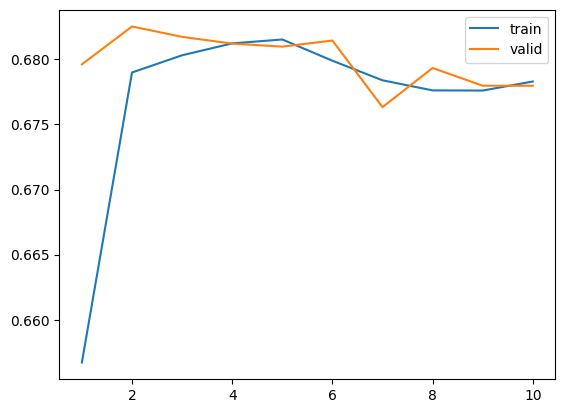

In [175]:
def graficar_accuracy(history):
    epoch_count = range(1, len(history['accuracy']) + 1)
    sns.lineplot(x=epoch_count,  y=history['accuracy'], label='train')
    sns.lineplot(x=epoch_count,  y=history['val_accuracy'], label='valid')
    plt.show()

graficar_accuracy(history1)

### 2.5. Inferencia

In [176]:
# Armar lo conversores de indice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [177]:
input_test = "My mother say hi."
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)
encoder_sequence_test_tensor = torch.from_numpy(encoder_sequence_test.astype(np.int32))

# Se obtiene la salida del encoder (el estado oculto para el decoder)
prev_state = model.encoder(encoder_sequence_test_tensor.to(device))

# Se inicializa la secuencia de entrada al decoder como "<sos>"
target_seq = np.zeros((1, 1))
target_seq[0, 0] = word2idx_outputs['<sos>']
target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

# Se obtiene la primera palabra de la secuencia de salida del decoder
output, prev_state = model.decoder(target_seq_tensor.to(device), prev_state)

top1 = output.argmax(1).view(-1, 1)
idx = int(top1.cpu())
print("Index/token de salida:", idx)

word = idx2word_target[idx]
print("Palabra de salida:", word)

Input: My mother say hi.
Representacion en vector de tokens de ids [15, 225, 134]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0  15 225 134]]
Index/token de salida: 6
Palabra de salida: tom


In [178]:
def translate_sentence(input_seq):
    # Se transforma la sequencia de entrada a los stados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder"
    prev_state = model.encoder(encoder_sequence_test_tensor.to(device))

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

    # Se obtiene el indice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']
    
    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output, new_prev_state = model.decoder(target_seq_tensor.to(device), prev_state)
        top1 = output.argmax(1).view(-1, 1)
        idx = int(top1.cpu())

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar ídx a palabra
        word = ''        
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dado la ultimo prediccion
        prev_state = new_prev_state

        # Actualizar secuencia de entrada con la salida (re-alimentacion)
        target_seq_tensor = top1

    return ' '.join(output_sentence)

In [179]:
input_test = "My mother say hi."
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)
encoder_sequence_test_tensor = torch.from_numpy(encoder_sequence_test.astype(np.int32))

translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: My mother say hi.
Representacion en vector de tokens de ids [15, 225, 134]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0  15 225 134]]
Response: tom


In [180]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
encoder_sequence_test_tensor = torch.from_numpy(input_seq.astype(np.int32))
translation = translate_sentence(encoder_sequence_test_tensor)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input: Mary wants to buy a dress.
Response: tom no quiero que


## 3. Aumentar tamaño dataset entrenamiento
Duplicamos el tamaño del dataset de entrenamiento a 12 líneas

In [181]:
MAX_NUM_SENTENCES = 12000
input_sentences, output_sentences, output_sentences_inputs = generar_secuencias(lines, MAX_NUM_SENTENCES)


salida_tokenizador = tokenizar_texto(input_sentences, output_sentences, output_sentences_inputs, MAX_VOCAB_SIZE)

input_tokenizer = salida_tokenizador["input_tokenizer"]
output_tokenizer = salida_tokenizador["output_tokenizer"]
input_integer_seq = salida_tokenizador["input_integer_seq"]
output_integer_seq = salida_tokenizador["output_integer_seq"]
output_input_integer_seq = salida_tokenizador["output_input_integer_seq"]
num_words_output = salida_tokenizador["num_words_output"]
word2idx_inputs = salida_tokenizador["word2idx_inputs"]
word2idx_outputs = salida_tokenizador["word2idx_outputs"]


encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
data_set = Data(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences)

valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False, drop_last=True)

# --- CONTROL DE ÍNDICES VÁLIDOS ---
num_words_input = len(word2idx_inputs) + 1  # +1 por padding
num_words_output = len(word2idx_outputs) + 1

encoder_input_sequences[encoder_input_sequences >= num_words_input] = 0
decoder_input_sequences[decoder_input_sequences >= num_words_output] = 0
decoder_output_sequences[decoder_output_sequences >= num_words_output] = 0





Palabras en el vocabulario: 5409
Sentencia de entrada más larga: 32
Palabras en el vocabulario: 8584
Sentencia de salida más larga: 36


In [182]:
embedding_matrix, words_not_found, nb_words = preparar_embedding_matrix(
    model_embeddings, word2idx_inputs, MAX_VOCAB_SIZE
)



encoder = Encoder(vocab_size=nb_words, embedding_matrix=embedding_matrix)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

model = Seq2Seq(encoder, decoder)
if cuda: model.cuda()

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

# Verificar que si el modelo ya existe para cargarlo. Sino entrenar
carpeta = "Modelos_entrenados/Aumentar_datos"

modelo_entrenado = check_checkpoint_exists(carpeta)

if not modelo_entrenado:
    history2 = train(model,
                    train_loader,
                    valid_loader,
                    optimizer,
                    criterion,
                    epochs=10
                    )
    config = {
        # Información general
        "max_input_len": max_input_len,
        "max_out_len": max_out_len,
        "max_vocab_size": MAX_VOCAB_SIZE,
        "cuda": cuda,

        # Hiperparámetros de embedding y red
        "embedding_dim": embedding_matrix.shape[1],
        "hidden_size": 128,        
        "num_layers": 1,            
        "lr": 0.1,
        "batch_size": 32,
        "epochs": 10,

        # Vocabularios (usar tamaños reales)
        "num_words_input": int(embedding_matrix.shape[0]),
        "num_words_output": int(num_words_output),

        # Checkpoint info (opcional)
        "embedding_source": getattr(model_embeddings, "name", "custom"),
    }
    save_checkpoint(carpeta, model, optimizer, history2, config,
                    input_tokenizer, output_tokenizer,
                    word2idx_inputs, word2idx_outputs, embedding_matrix)
else:
    data = load_checkpoint(carpeta, Encoder, Decoder, Seq2Seq, device="cuda" if cuda else "cpu")
    model = data["model"]
    optimizer = data["optimizer"]
    history2 = data["history"]


Número de embeddings nulos: 53
Faltan archivos en el checkpoint: ['seq2seq_model.pth', 'optimizer_state.pth', 'config.pth', 'embedding_matrix.npy', 'input_tokenizer.pkl', 'output_tokenizer.pkl', 'word2idx_inputs.pkl', 'word2idx_outputs.pkl', 'history.json']


Epoch 01/10 | Train loss: 2.527 | Train acc: 0.664 | Val loss: 2.189 | Val acc: 0.687


Epoch 02/10 | Train loss: 2.196 | Train acc: 0.675 | Val loss: 2.196 | Val acc: 0.689


Epoch 03/10 | Train loss: 2.152 | Train acc: 0.675 | Val loss: 2.257 | Val acc: 0.683


Epoch 04/10 | Train loss: 2.146 | Train acc: 0.674 | Val loss: 2.249 | Val acc: 0.688


Epoch 05/10 | Train loss: 2.149 | Train acc: 0.673 | Val loss: 2.300 | Val acc: 0.686


Epoch 06/10 | Train loss: 2.164 | Train acc: 0.671 | Val loss: 2.329 | Val acc: 0.685


Epoch 07/10 | Train loss: 2.176 | Train acc: 0.671 | Val loss: 2.337 | Val acc: 0.684


Epoch 08/10 | Train loss: 2.156 | Train acc: 0.671 | Val loss: 2.358 | Val acc: 0.684


Epoch 09/10 | Train loss: 2.155 | Train acc: 0.670 | Val loss: 2.393 | Val acc: 0.685


Epoch 10/10 | Train loss: 2.180 | Train acc: 0.670 | Val loss: 2.424 | Val acc: 0.684
Checkpoint guardado en: Modelos_entrenados/Aumentar_datos


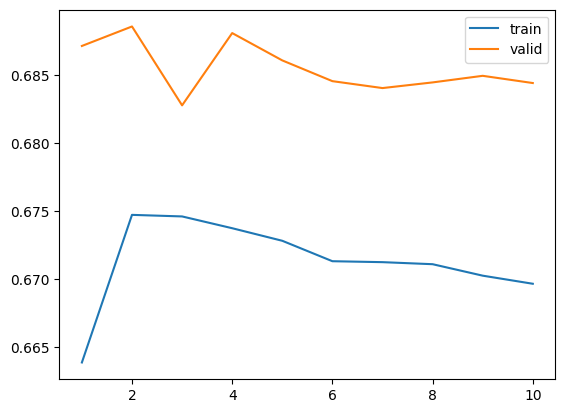

In [183]:
graficar_accuracy(history2)

## 4. Aumentar tamaño de las secuencias
Aumentamos el tamaño de input maximo a 25 (la más larga en el dataset es 32) y del output a 30 (la más larga en el dataset es 36)

In [184]:
MAX_NUM_SENTENCES = 6000
max_input_len = 25
max_out_len = 30

input_sentences, output_sentences, output_sentences_inputs = generar_secuencias(lines, MAX_NUM_SENTENCES)


salida_tokenizador = tokenizar_texto(input_sentences, output_sentences, output_sentences_inputs, MAX_VOCAB_SIZE)

input_tokenizer = salida_tokenizador["input_tokenizer"]
output_tokenizer = salida_tokenizador["output_tokenizer"]
input_integer_seq = salida_tokenizador["input_integer_seq"]
output_integer_seq = salida_tokenizador["output_integer_seq"]
output_input_integer_seq = salida_tokenizador["output_input_integer_seq"]
num_words_output = salida_tokenizador["num_words_output"]
word2idx_inputs = salida_tokenizador["word2idx_inputs"]
word2idx_outputs = salida_tokenizador["word2idx_outputs"]


encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
data_set = Data(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences)

valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False, drop_last=True)

Palabras en el vocabulario: 3851
Sentencia de entrada más larga: 32
Palabras en el vocabulario: 5721
Sentencia de salida más larga: 36


In [185]:
nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs) + 1)
embedding_matrix, words_not_found, nb_words = preparar_embedding_matrix(model_embeddings, word2idx_inputs, MAX_VOCAB_SIZE)

encoder = Encoder(vocab_size=nb_words, embedding_matrix=embedding_matrix)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

model = Seq2Seq(encoder, decoder)
if cuda: model.cuda()

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica


# Verificar que si el modelo ya existe para cargarlo. Sino entrenar
carpeta = "Modelos_entrenados/Aumentar_secuencias"

modelo_entrenado = check_checkpoint_exists(carpeta)

if not modelo_entrenado:
    history3 = train(model,
                    train_loader,
                    valid_loader,
                    optimizer,
                    criterion,
                    epochs=10
                    )
    config = {
        # Información general
        "max_input_len": max_input_len,
        "max_out_len": max_out_len,
        "max_vocab_size": MAX_VOCAB_SIZE,
        "cuda": cuda,

        # Hiperparámetros de embedding y red
        "embedding_dim": embedding_matrix.shape[1],
        "hidden_size": 128,        
        "num_layers": 1,           
        "lr": 0.1,
        "batch_size": 32,
        "epochs": 10,

        # Vocabularios (usar tamaños reales)
        "num_words_input": int(embedding_matrix.shape[0]),
        "num_words_output": int(num_words_output),

        # Checkpoint info (opcional)
        "embedding_source": getattr(model_embeddings, "name", "custom"),
    }
    save_checkpoint(carpeta, model, optimizer, history3, config,
                    input_tokenizer, output_tokenizer,
                    word2idx_inputs, word2idx_outputs, embedding_matrix)
else:
    data = load_checkpoint(carpeta, Encoder, Decoder, Seq2Seq, device="cuda" if cuda else "cpu")
    model = data["model"]
    optimizer = data["optimizer"]
    history3 = data["history"]




Número de embeddings nulos: 30
Faltan archivos en el checkpoint: ['seq2seq_model.pth', 'optimizer_state.pth', 'config.pth', 'embedding_matrix.npy', 'input_tokenizer.pkl', 'output_tokenizer.pkl', 'word2idx_inputs.pkl', 'word2idx_outputs.pkl', 'history.json']


Epoch 01/10 | Train loss: 1.861 | Train acc: 0.772 | Val loss: 1.561 | Val acc: 0.799


Epoch 02/10 | Train loss: 1.335 | Train acc: 0.801 | Val loss: 1.559 | Val acc: 0.803


Epoch 03/10 | Train loss: 1.191 | Train acc: 0.805 | Val loss: 1.585 | Val acc: 0.804


Epoch 04/10 | Train loss: 1.113 | Train acc: 0.809 | Val loss: 1.626 | Val acc: 0.801


Epoch 05/10 | Train loss: 1.057 | Train acc: 0.813 | Val loss: 1.672 | Val acc: 0.801


Epoch 06/10 | Train loss: 1.023 | Train acc: 0.815 | Val loss: 1.703 | Val acc: 0.800


Epoch 07/10 | Train loss: 1.007 | Train acc: 0.817 | Val loss: 1.740 | Val acc: 0.800


Epoch 08/10 | Train loss: 0.996 | Train acc: 0.819 | Val loss: 1.776 | Val acc: 0.803


Epoch 09/10 | Train loss: 0.996 | Train acc: 0.818 | Val loss: 1.784 | Val acc: 0.799


Epoch 10/10 | Train loss: 0.981 | Train acc: 0.819 | Val loss: 1.792 | Val acc: 0.801
Checkpoint guardado en: Modelos_entrenados/Aumentar_secuencias


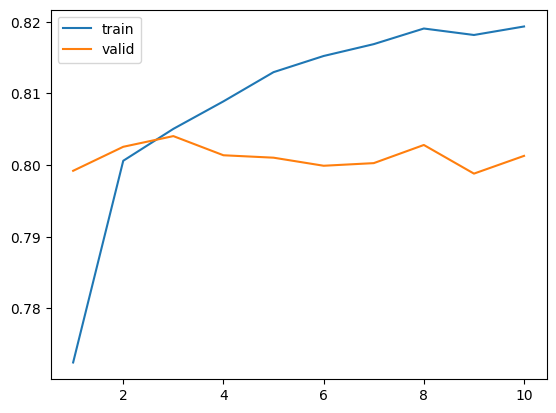

In [186]:
graficar_accuracy(history3)

Se observa una mejora significativa del accuracy respecto a las variantes anteriores, por lo que se mantiene la modificación para las siguientes variantes a entrenar:

## 5. Aumentar cantidad de hidden units de LSTM

In [187]:
class Encoder_2(nn.Module):
    def __init__(self, vocab_size, embedding_matrix):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 256
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1]
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)

class Decoder_2(nn.Module):
    def __init__(self, vocab_size, output_dim, embedding_matrix=None):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 256
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1] if embedding_matrix is not None else 50
        self.output_dim = output_dim

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)

        # Para utilizar versión con embedding preentrenados
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            self.embedding.weight.requires_grad = False  # 

        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim) # Fully connected layer


    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        out = self.fc1(lstm_output[:,-1,:])
        return out, (ht, ct)

In [188]:
encoder = Encoder_2(vocab_size=nb_words, embedding_matrix=embedding_matrix)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder_2(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

model = Seq2Seq(encoder, decoder)
if cuda: model.cuda()

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

# Verificar que si el modelo ya existe para cargarlo. Sino entrenar
carpeta = "Modelos_entrenados/Aumentar_hidden_size"

modelo_entrenado = check_checkpoint_exists(carpeta)

n_epochs = 10

if not modelo_entrenado:
    history4 = train(model,
                    train_loader,
                    valid_loader,
                    optimizer,
                    criterion,
                    epochs=n_epochs
                    )
    config = {
        # Información general
        "max_input_len": max_input_len,
        "max_out_len": max_out_len,
        "max_vocab_size": MAX_VOCAB_SIZE,
        "cuda": cuda,

        # Hiperparámetros de embedding y red
        "embedding_dim": embedding_matrix.shape[1],
        "hidden_size": 256,      
        "num_layers": 1,           
        "lr": 0.1,
        "batch_size": 32,
        "epochs": n_epochs,

        # Vocabularios (usar tamaños reales)
        "num_words_input": int(embedding_matrix.shape[0]),
        "num_words_output": int(num_words_output),

        # Checkpoint info (opcional)
        "embedding_source": getattr(model_embeddings, "name", "custom"),
    }
    save_checkpoint(carpeta, model, optimizer, history4, config,
                    input_tokenizer, output_tokenizer,
                    word2idx_inputs, word2idx_outputs, embedding_matrix)
else:
    data = load_checkpoint(carpeta, Encoder_2, Decoder_2, Seq2Seq, device="cuda" if cuda else "cpu")
    model = data["model"]
    optimizer = data["optimizer"]
    history4 = data["history"]

Checkpoint completo encontrado en: Modelos_entrenados/Aumentar_hidden_size
No se encontró embedding_matrix_decoder.npy — se entrenará embedding en el Decoder.
Checkpoint cargado desde: Modelos_entrenados/Aumentar_hidden_size


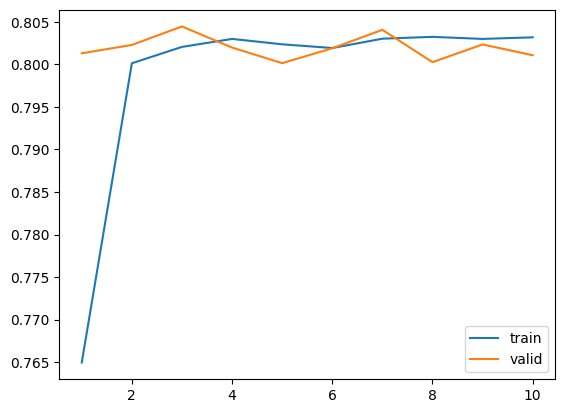

In [189]:
graficar_accuracy(history4)

## 6. Aumentar cantidad de celdas LSTM

In [190]:
class Encoder_3(nn.Module):
    def __init__(self, vocab_size, embedding_matrix):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size1 = 128
        self.lstm_size2 = 64
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1]
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        # Primer LSTM
        self.lstm1 = nn.LSTM(input_size=self.embedding_dim,
                             hidden_size=self.lstm_size1,
                             batch_first=True,
                             num_layers=self.num_layers)

        # Segundo LSTM, recibe como input la salida del primero
        self.lstm2 = nn.LSTM(input_size=self.lstm_size1,
                             hidden_size=self.lstm_size2,
                             batch_first=True,
                             num_layers=self.num_layers)

    def forward(self, x):
        out = self.embedding(x)
        lstm_out1, (h1, c1) = self.lstm1(out)  # [batch_size, seq_len, lstm_size1]
        lstm_out2, (h2, c2) = self.lstm2(lstm_out1)  # [batch_size, seq_len, lstm_size2]

        # Retornar hidden y cell del último LSTM
        return h2, c2

class Decoder_3(nn.Module):
    def __init__(self, vocab_size, output_dim, embedding_matrix=None):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size1 = 128
        self.lstm_size2 = 64
        self.num_layers = 1 
        self.embedding_dim = embedding_matrix.shape[1] if embedding_matrix is not None else 50
        self.output_dim = output_dim

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)

        # Para utilizar versión con embedding preentrenados
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            self.embedding.weight.requires_grad = False  # 

        # Primer LSTM
        self.lstm1 = nn.LSTM(input_size=self.embedding_dim,
                             hidden_size=self.lstm_size1,
                             batch_first=True,
                             num_layers=self.num_layers)

        # Segundo LSTM, recibe como input la salida del primero
        self.lstm2 = nn.LSTM(input_size=self.lstm_size1,
                             hidden_size=self.lstm_size2,
                             batch_first=True,
                             num_layers=self.num_layers)

        self.fc1 = nn.Linear(in_features=self.lstm_size2, out_features=self.output_dim) # Fully connected layer


    def forward(self, x, prev_state):
        out = self.embedding(x)
        # Primera LSTM SIN estado inicial (128)
        lstm_out1, _ = self.lstm1(out)
        # Segunda LSTM CON el estado del encoder (64)
        lstm_out2, (ht2, ct2) = self.lstm2(lstm_out1, prev_state)
        out = self.fc1(lstm_out2[:,-1,:])
        return out, (ht2, ct2)

class Seq2Seq_3(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        assert encoder.lstm_size2 == decoder.lstm_size2, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, encoder_input, decoder_input):
        batch_size = decoder_input.shape[0]
        decoder_input_len = decoder_input.shape[1]
        vocab_size = self.decoder.output_dim
        
        # tensor para almacenar la salida
        # (batch_size, sentence_len, one_hot_size)
        outputs = torch.zeros(batch_size, decoder_input_len, vocab_size)
        
        # ultimo hidden state del encoder, primer estado oculto del decoder
        prev_state = self.encoder(encoder_input)
      
        # En la primera iteracion se toma el primer token de target (<sos>)
        input = decoder_input[:, 0:1]

        for t in range(decoder_input_len):
            # t --> token index

            # utilizamos método "teacher forcing", es decir que durante
            # el entrenamiento no realimentamos la salida del decoder
            # sino el token correcto que sigue en target
            input = decoder_input[:, t:t+1]

            # ingresar cada token embedding, uno por uno junto al hidden state
            # recibir el output del decoder (softmax)
            output, prev_state = self.decoder(input, prev_state)
            top1 = output.argmax(1).view(-1, 1)

            # Sino se usará "teacher forcing" habría que descomentar
            # esta linea.
            # Hay ejemplos dandos vuelta en donde se utilza un random 
            # para ver en cada vuelta que técnica se aplica
            #input = top1            

            # guardar cada salida (softmax)
            outputs[:, t, :] = output

        return outputs


In [191]:
encoder = Encoder_3(vocab_size=nb_words, embedding_matrix=embedding_matrix)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder_3(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

model = Seq2Seq_3(encoder, decoder)
if cuda: model.cuda()

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

# Verificar que si el modelo ya existe para cargarlo. Sino entrenar
carpeta = "Modelos_entrenados/Aumentar_capas_LSTM"

modelo_entrenado = check_checkpoint_exists(carpeta)

n_epochs = 10

if not modelo_entrenado:
    history5 = train(model,
                    train_loader,
                    valid_loader,
                    optimizer,
                    criterion,
                    epochs=n_epochs
                    )
    config = {
        # Información general
        "max_input_len": max_input_len,
        "max_out_len": max_out_len,
        "max_vocab_size": MAX_VOCAB_SIZE,
        "cuda": cuda,

        # Hiperparámetros de embedding y red
        "embedding_dim": embedding_matrix.shape[1],
        "hidden_size": 128,        
        "hidden_size_lstm2": 64,
        "num_layers": 1,          
        "lr": 0.1,
        "batch_size": 32,
        "epochs": n_epochs,

        # Vocabularios (usar tamaños reales)
        "num_words_input": int(embedding_matrix.shape[0]),
        "num_words_output": int(num_words_output),

        # Checkpoint info (opcional)
        "embedding_source": getattr(model_embeddings, "name", "custom"),
    }
    save_checkpoint(carpeta, model, optimizer, history5, config,
                    input_tokenizer, output_tokenizer,
                    word2idx_inputs, word2idx_outputs, embedding_matrix)
else:
    data = load_checkpoint(carpeta, Encoder_3, Decoder_3, Seq2Seq_3, device="cuda" if cuda else "cpu")
    model = data["model"]
    optimizer = data["optimizer"]
    history5 = data["history"]

Faltan archivos en el checkpoint: ['seq2seq_model.pth', 'optimizer_state.pth', 'config.pth', 'embedding_matrix.npy', 'input_tokenizer.pkl', 'output_tokenizer.pkl', 'word2idx_inputs.pkl', 'word2idx_outputs.pkl', 'history.json']


Epoch 01/10 | Train loss: 1.557 | Train acc: 0.793 | Val loss: 1.379 | Val acc: 0.809


Epoch 02/10 | Train loss: 1.324 | Train acc: 0.805 | Val loss: 1.402 | Val acc: 0.807


Epoch 03/10 | Train loss: 1.275 | Train acc: 0.806 | Val loss: 1.392 | Val acc: 0.810


Epoch 04/10 | Train loss: 1.251 | Train acc: 0.806 | Val loss: 1.403 | Val acc: 0.809


Epoch 05/10 | Train loss: 1.226 | Train acc: 0.806 | Val loss: 1.418 | Val acc: 0.809


Epoch 06/10 | Train loss: 1.211 | Train acc: 0.807 | Val loss: 1.418 | Val acc: 0.810


Epoch 07/10 | Train loss: 1.198 | Train acc: 0.807 | Val loss: 1.427 | Val acc: 0.811


Epoch 08/10 | Train loss: 1.193 | Train acc: 0.807 | Val loss: 1.441 | Val acc: 0.810


Epoch 09/10 | Train loss: 1.204 | Train acc: 0.807 | Val loss: 1.455 | Val acc: 0.811


Epoch 10/10 | Train loss: 1.196 | Train acc: 0.807 | Val loss: 1.468 | Val acc: 0.807
Checkpoint guardado en: Modelos_entrenados/Aumentar_capas_LSTM


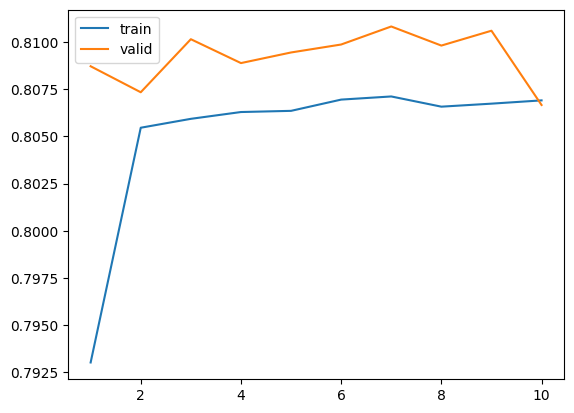

In [192]:
graficar_accuracy(history5)

## 7. LSTM bidireccional Encoder
Ahora se modifica la LSTM por una bidireccional. Esto se hace solamente en el Encoder, ya que el Decoder no puede utilizar información futura

In [193]:
class Encoder_bidireccional(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, dropout_rate=0.2):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 128
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1]
        self.dropout_rate = dropout_rate
        
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        
        # Dropout después del embedding
        self.dropout_embedding = nn.Dropout(self.dropout_rate)
        
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,
            batch_first=True,
            num_layers=self.num_layers,
            bidirectional=True,
            dropout=self.dropout_rate if self.num_layers > 1 else 0  # Solo si hay múltiples capas
        )

    def forward(self, x):
        out = self.embedding(x)
        out = self.dropout_embedding(out)  # Dropout después del embedding
        lstm_output, (ht, ct) = self.lstm(out)
        
        # CAMBIO CLAVE: Usar solo el estado forward para evitar problemas de dimensiones
        # Esto mantiene la ventaja bidireccional del encoder pero evita incompatibilidades
        ht_forward = ht[0].unsqueeze(0)  # Solo forward, shape (1, batch, 128)
        ct_forward = ct[0].unsqueeze(0)  # Solo forward, shape (1, batch, 128)
        
        return (ht_forward, ct_forward)

class Decoder_bidreccional(nn.Module):
    def __init__(self, vocab_size, output_dim, embedding_matrix=None, dropout_rate=0.2):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 128  # Mismo tamaño que el encoder (no bidireccional)
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1] if embedding_matrix is not None else 50
        self.output_dim = output_dim
        self.dropout_rate = dropout_rate

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)

        # Para utilizar versión con embedding preentrenados
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            self.embedding.weight.requires_grad = False  # 

        # Dropout después del embedding
        self.dropout_embedding = nn.Dropout(self.dropout_rate)

        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,  # 128 - compatible con encoder
            batch_first=True,
            num_layers=self.num_layers,
            dropout=self.dropout_rate if self.num_layers > 1 else 0  # Solo si hay múltiples capas
        )
        
        # Dropout antes de la capa final
        self.dropout_output = nn.Dropout(self.dropout_rate)
        self.fc1 = nn.Linear(self.lstm_size, self.output_dim)
        # SIN SOFTMAX - usar solo logits para evitar problemas de gradientes

    def forward(self, x, prev_state):
        out = self.embedding(x)
        out = self.dropout_embedding(out)  # Dropout después del embedding
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        out = self.dropout_output(lstm_output[:,-1,:])  # Dropout antes de la capa final
        out = self.fc1(out)  # Solo logits, sin softmax
        return out, (ht, ct)


In [194]:
# Crear el modelo bidireccional con dropout
dropout_rate = 0.2  # 20% de dropout por defecto

encoder_bidireccional = Encoder_bidireccional(vocab_size=nb_words, 
                                            embedding_matrix=embedding_matrix, 
                                            dropout_rate=dropout_rate)
if cuda: encoder_bidireccional.to(device)

# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder_bidreccional = Decoder_bidreccional(vocab_size=num_words_output, 
                                          output_dim=num_words_output,
                                          dropout_rate=dropout_rate)
if cuda: decoder_bidreccional.to(device)

model = Seq2Seq(encoder_bidireccional, decoder_bidreccional)
if cuda: model.to(device)

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Learning rate más conservador
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

print(f"✓ Modelo bidireccional creado con dropout_rate = {dropout_rate}")
print(f"✓ Learning rate = 0.01")
print(f"✓ Dispositivo: {'CUDA' if cuda else 'CPU'}")

# Verificar que si el modelo ya existe para cargarlo. Sino entrenar
carpeta = "Modelos_entrenados/LSTM_bidireccional"

modelo_entrenado = check_checkpoint_exists(carpeta)

n_epochs = 20

if not modelo_entrenado:
    print(f"\nIniciando entrenamiento por {n_epochs} épocas...")
    history6 = train(model,
                    train_loader,
                    valid_loader,
                    optimizer,
                    criterion,
                    epochs=n_epochs
                    )
    config = {
        # Información general
        "max_input_len": max_input_len,
        "max_out_len": max_out_len,
        "max_vocab_size": MAX_VOCAB_SIZE,
        "cuda": cuda,

        # Hiperparámetros de embedding y red
        "embedding_dim": embedding_matrix.shape[1],
        "hidden_size": 128,      
        "num_layers": 1,           
        "lr": 0.01,  # Learning rate más conservador
        "dropout_rate": dropout_rate,  # Nuevo parámetro
        "batch_size": 32,
        "epochs": n_epochs,

        # Vocabularios (usar tamaños reales)
        "num_words_input": int(embedding_matrix.shape[0]),
        "num_words_output": int(num_words_output),

        # Checkpoint info (opcional)
        "embedding_source": getattr(model_embeddings, "name", "custom"),
    }
    save_checkpoint(carpeta, model, optimizer, history6, config,
                    input_tokenizer, output_tokenizer,
                    word2idx_inputs, word2idx_outputs, embedding_matrix)
    print("Modelo entrenado y guardado exitosamente")
else:
    print(f"\nCargando modelo existente desde {carpeta}")
    data = load_checkpoint(carpeta, Encoder_bidireccional, Decoder_bidreccional, Seq2Seq, device="cuda" if cuda else "cpu")
    model = data["model"]
    optimizer = data["optimizer"]
    history6 = data["history"]
    print("Modelo cargado exitosamente")


✓ Modelo bidireccional creado con dropout_rate = 0.2
✓ Learning rate = 0.01
✓ Dispositivo: CPU
Checkpoint completo encontrado en: Modelos_entrenados/LSTM_bidireccional

Cargando modelo existente desde Modelos_entrenados/LSTM_bidireccional
No se encontró embedding_matrix_decoder.npy — se entrenará embedding en el Decoder.
Checkpoint cargado desde: Modelos_entrenados/LSTM_bidireccional
Modelo cargado exitosamente


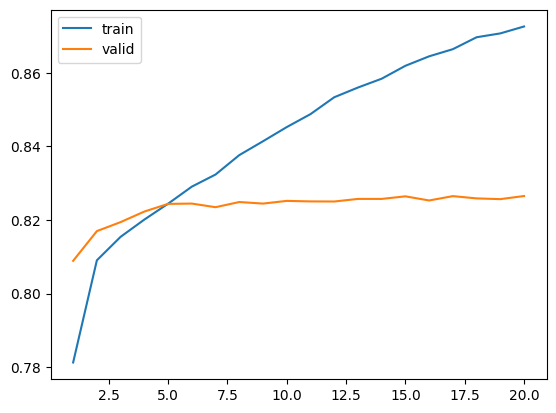

In [195]:
graficar_accuracy(history6)
